In [22]:
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer

import tensorflow as tf
from keras.layers import Dense, Dropout, Embedding, LSTM, TextVectorization
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
tf.config.list_physical_devices(device_type="GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
df = pd.read_table("train.tsv")
test_df = pd.read_table("test.tsv")

In [5]:
stop_word_set = set(stopwords.words("english"))
toktok_tokenizer = ToktokTokenizer()
lemmatizer = WordNetLemmatizer()


def custom_standardization(text):
    text = text.lower()
    tokens = toktok_tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    tokens = [token for token in tokens if token not in stop_word_set]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(tokens)

In [6]:
df["Phrase"] = df["Phrase"].astype(str).apply(custom_standardization)
test_df["Phrase"] = test_df["Phrase"].astype(str).apply(custom_standardization)

In [7]:
df.Phrase[:5]

0    series escapade demonstrating adage good goose...
1       series escapade demonstrating adage good goose
2                                               series
3                                                     
4                                               series
Name: Phrase, dtype: object

In [23]:
batch_size = 256
seed = 42

train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed)

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["Phrase"], to_categorical(train_df["Sentiment"]))
).batch(batch_size)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df["Phrase"], to_categorical(val_df["Sentiment"]))
).batch(batch_size)

In [24]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
vocab_size = 10000
sequence_length = 40

text_vectorize_layer = TextVectorization(
    standardize="lower",
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [26]:
# text-only dataset without labels
text_ds = train_ds.map(lambda x, y: x)
# call `adapt` to build the vocabulary
text_vectorize_layer.adapt(text_ds)

In [27]:
early_stopping = EarlyStopping(
    min_delta=0.001, mode="max", monitor="val_accuracy", patience=1
)
callback = [early_stopping]

In [36]:
embedding_dim = 256

model = Sequential(
    [
        text_vectorize_layer,
        Embedding(vocab_size, embedding_dim, input_length=sequence_length),
        LSTM(256, dropout=0.5, recurrent_dropout=0.5, return_sequences=True),
        LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=False),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(5, activation="softmax"),
    ]
)
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 40)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 40, 256)           2560000   
                                                                 
 lstm_10 (LSTM)              (None, 64)                82176     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                      

In [39]:
history = model.fit(
    train_ds, validation_data=val_ds, epochs=6, batch_size=256, callbacks=callback
)

Epoch 1/6
488/488 [==============================] - 50s 102ms/step - loss: 0.7348 - accuracy: 0.6927 - val_loss: 0.8947 - val_accuracy: 0.6520
Epoch 2/6
488/488 [==============================] - 50s 102ms/step - loss: 0.7263 - accuracy: 0.6958 - val_loss: 0.9005 - val_accuracy: 0.6532
Epoch 3/6
488/488 [==============================] - 50s 102ms/step - loss: 0.7167 - accuracy: 0.6977 - val_loss: 0.9146 - val_accuracy: 0.6533
Epoch 4/6
488/488 [==============================] - 50s 102ms/step - loss: 0.7077 - accuracy: 0.7009 - val_loss: 0.9143 - val_accuracy: 0.6545
Epoch 5/6
488/488 [==============================] - 50s 102ms/step - loss: 0.7013 - accuracy: 0.7019 - val_loss: 0.9218 - val_accuracy: 0.6535
Epoch 6/6
488/488 [==============================] - 50s 102ms/step - loss: 0.6938 - accuracy: 0.7055 - val_loss: 0.9349 - val_accuracy: 0.6532


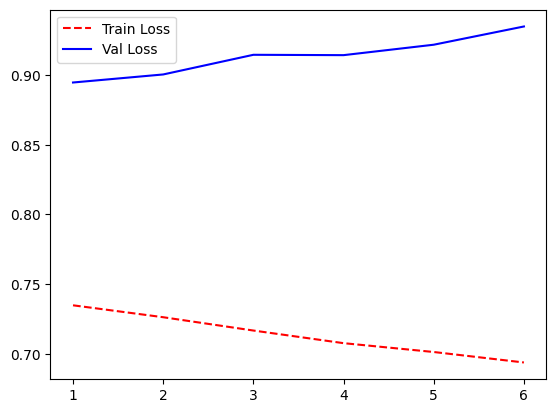

In [40]:
epoch_count = range(1, len(history.history["loss"]) + 1)
plt.plot(epoch_count, history.history["loss"], "r--")
plt.plot(epoch_count, history.history["val_loss"], "b-")
plt.legend(["Train Loss", "Val Loss"])
plt.show()

In [41]:
preds = model.predict(test_df["Phrase"].values)
predictions = np.array([np.argmax(p) for p in preds])
sub_file = pd.read_csv("sampleSubmission.csv", sep=",")
sub_file.Sentiment = predictions
sub_file.to_csv("Submission.csv", index=False)

2072/2072 [==============================] - 22s 10ms/step
